In [31]:
import numpy as np
from scipy.fftpack import dct, idct
from scipy.ndimage import gaussian_filter
from PIL import Image
import itertools
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import os

In [51]:
def load_image(image_path):
    from PIL import Image
    return Image.open(image_path)

# Helper function to convert image to YCbCr color space
def convert_to_YCbCr(image):
    # Convert the image to RGB if it's not already
    if image.mode != 'RGB':
        image = image.convert('RGB')
        
    # Convert the image to a NumPy array
    rgb_image = np.array(image)

    # Define the transformation matrix
    transformation_matrix = np.array([
        [1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3)],
        [1 / np.sqrt(6), 0, -1 / np.sqrt(6)],
        [1 / (3 * np.sqrt(2)), -2 / (3 * np.sqrt(2)), 1 / (3 * np.sqrt(2))]
    ])

    # Reshape the RGB image to a column vector
    rgb_vector = rgb_image.reshape(-1, 3)

    # Apply the transformation
    ycc_matrix = np.dot(transformation_matrix, rgb_vector.T).T

    # Reshape the result back to the original image shape
    ycc_image = ycc_matrix.reshape(rgb_image.shape)

    # Extract the transformed Y, Cb, and Cr components
    Y_matrix = ycc_image[:, :, 0]
    Cb_matrix = ycc_image[:, :, 1]
    Cr_matrix = ycc_image[:, :, 2]
    # Y_matrix= ((Y_matrix - np.min(Y_matrix)) / (np.max(Y_matrix) - np.min(Y_matrix))) * 255
    # Cb_matrix = ((Cb_matrix - np.min(Cb_matrix)) / (np.max(Cb_matrix) - np.min(Cb_matrix))) * 255
    # Cr_matrix = ((Cr_matrix - np.min(Cr_matrix)) / (np.max(Cr_matrix) - np.min(Cr_matrix))) * 255
    # Y_matrix = Y_matrix.astype(np.uint8)
    # Cb_matrix =  Cb_matrix.astype(np.uint8)
    # Cr_matrix = Cr_matrix.astype(np.uint8)
    # Y_matrix = Y_matrix.astype(np.uint8)
    # Cb_matrix = Cb_matrix.astype(np.uint8)
    # Cr_matrix = Cr_matrix.astype(np.uint8)
    # plt.imshow(Y_normalized)
    # plt.title("Y_matrix")
    # plt.axis('off')
    # plt.show()
    # print("Y = ",  Y_matrix)
    # print("Cb = ",  Cb_matrix)
    # print("Cr = ",   Cr_matrix)
    # Return the Y, Cb, and Cr matrices
    return Y_matrix, Cb_matrix, Cr_matrix

# Helper function to convert YCbCr back to RGB
def convert_to_RGB(Y, Cb, Cr):
    Y = Y.astype(float)
    Cb = Cb.astype(float)
    Cr = Cr.astype(float)

    R = Y + 1.402 * (Cr - 128)
    G = Y - 0.344136 * (Cb - 128) - 0.714136 * (Cr - 128)
    B = Y + 1.772 * (Cb - 128)

    R = np.clip(R, 0, 255).astype(np.uint8)
    G = np.clip(G, 0, 255).astype(np.uint8)
    B = np.clip(B, 0, 255).astype(np.uint8)

    rgb_reconstructed = np.stack((R, G, B), axis=-1)
    reconstructed_image = Image.fromarray(rgb_reconstructed)

    # Display the reconstructed image
    plt.imshow(reconstructed_image, cmap="gray")
    plt.title("Reconstructed RGB Image")
    plt.axis('off')
    plt.show()

def compute_2d_dct(image_matrix):
    return dct(dct(image_matrix.T, norm='ortho').T, norm='ortho')

def compute_2d_idct(dct_matrix):
    idct1 = idct(idct(dct_matrix.T, norm='ortho').T, norm='ortho')
    return idct1

def threshold_dct(dct_coefficients, threshold):
    thresholded_dct = np.copy(dct_coefficients)
    for k in range(dct_coefficients.shape[0]):
        for l in range(dct_coefficients.shape[1]):
            if k == 0 and l == 0:
                continue
            else:
                if dct_coefficients[k, l] > threshold:
                    thresholded_dct[k, l] = dct_coefficients[k,l] - threshold
                elif dct_coefficients[k, l] < -threshold:
                    thresholded_dct[k, l] = threshold + dct_coefficients[k,l]
                elif np.abs(dct_coefficients[k, l]) <= threshold:
                    thresholded_dct[k, l] = 0
    
    # print("Thresholded DCT = ", np.array2string(thresholded_dct, separator=', '))
    return thresholded_dct

def compute_alpha(dct_coefficients, X):
    # print("FOR Y")
    N = len(dct_coefficients)
    F_00 = dct_coefficients[0, 0]
    sum_of_absolute_values = np.sum(np.abs(dct_coefficients))
    E = (sum_of_absolute_values - np.abs(F_00)) / ((N * N) - 1)
    En = E* -X + 1
    Alpha = (1 - 0.0052 * E) * En
    # print("En = ", En)
    # print("E = ", E)
    # print("Alpha = ", Alpha)
    return Alpha

def compute_alphaC(dct_coefficients, X):
    # print("FOR C")
    N = len(dct_coefficients)
    F_00 = dct_coefficients[0, 0]
    sum_of_absolute_values = np.sum(np.abs(dct_coefficients))
    E = (sum_of_absolute_values - np.abs(F_00)) / ((N * N) - 1)
    En = E * -X + 1
    Alpha = (1 - 0.0082 * E) * En
    # print("En = ", En)
    # print("E = ", E)
    # print("Alpha = ", Alpha)
    return Alpha

def calculate_Eh_Ev(dct_coefficients):
    rows, cols = dct_coefficients.shape
    Eh = 0
    Ev = 0
    for k in range(rows):
        for l in range(cols):
            Wh = 1 if k > l else 0
            Wv = 1 if k < l else 0
            Eh += Wh * abs(dct_coefficients[k, l])
            Ev += Wv * abs(dct_coefficients[k, l])
    return Eh, Ev

def calculate_THV(rows, cols, Eh, Ev):
    T = np.zeros((rows, cols))
    H = np.zeros((rows, cols))
    V = np.zeros((rows, cols))
    
    for k in range(rows):
        for l in range(cols):
            k_val = k if k != 0 else 1
            l_val = l if l != 0 else 1
            
            H[k, l] = 1.25 - (np.arctan(l_val / k_val) * 180 / np.pi) / 90
            V[k, l] = 0.25 + (np.arctan(k_val / l_val) * 180 / np.pi) / 90
            T[k, l] = (Eh / (Eh + Ev)) * H[k, l] + (Ev / (Eh + Ev)) * V[k, l]
    return T, H, V

def calculateTKL(dct_coefficients, threshold, X):
    rows, cols = dct_coefficients.shape
    Th = threshold_dct(dct_coefficients, threshold) 
    Eh, Ev = calculate_Eh_Ev(dct_coefficients)
    
    # Compute Th and T based on their respective functions
    T , H, V = calculate_THV(rows, cols, Eh, Ev)
    Th = threshold_dct(dct_coefficients, threshold)  # Threshold value set to 20, modify if needed
    alpha = compute_alpha(dct_coefficients, X)
    F_doubleprime = np.copy(dct_coefficients)
    
    # Preserve the DC coefficient (0, 0)
    F_doubleprime[0, 0] = dct_coefficients[0, 0]
    
    # Modify AC coefficients according to equation (11)
    for k in range(rows):
        for l in range(cols):
            if (k, l) != (0, 0):  # Skip the DC coefficient
                F_doubleprime[k, l] = (1 - alpha) * Th[k, l] * T[k, l]
    
    np.set_printoptions(formatter={'float': lambda x: "{:.6f}".format(x)})
    return F_doubleprime


def calculateTKLC(dct_coefficients, threshold, X):
    rows, cols = dct_coefficients.shape
    Th = threshold_dct(dct_coefficients, threshold) 
    Eh, Ev = calculate_Eh_Ev(dct_coefficients)
    
    # Compute Th and T based on their respective functions
    T , H, V = calculate_THV(rows, cols, Eh, Ev)
    Th = threshold_dct(dct_coefficients, threshold)  # Threshold value set to 20, modify if needed
    
    alpha = compute_alphaC(dct_coefficients, X)
    F_doubleprime = np.copy(dct_coefficients)
    
    # Preserve the DC coefficient (0, 0)
    F_doubleprime[0, 0] = dct_coefficients[0, 0]
    
    # Modify AC coefficients according to equation (11)
    for k in range(rows):
        for l in range(cols):
            if (k, l) != (0, 0):  # Skip the DC coefficient
                F_doubleprime[k, l] = (1 - alpha) * Th[k, l] * T[k, l]
                
    np.set_printoptions(formatter={'float': lambda x: "{:.6f}".format(x)})
    return F_doubleprime

def combine_channels(Y, Cb, Cr):

    ycc_matrix = np.stack((Y, Cb, Cr), axis=-1)

    # Define the transformation matrix
    transformation_matrix = np.array([
    [1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3)],
    [1 / np.sqrt(6), 0, -1 / np.sqrt(6)],
    [1 / (3 * np.sqrt(2)), -2 / (3 * np.sqrt(2)), 1 / (3 * np.sqrt(2))]
    
    ])
    
    # Inverse of the transformation matrix
    inverse_transformation_matrix = np.linalg.inv(transformation_matrix)

    # Assuming Y_image, C1_image, C2_image are the matrices we obtained earlier and have the same shape
    # Recombine the Y, C1, and C2 channels into a single matrix
    ycc_combined = np.stack((Y, Cb, Cr), axis=-1)

    # Reshape the combined YC1C2 image to a column vector for matrix multiplication
    ycc_vector = ycc_combined.reshape(-1, 3)

    # Apply the inverse transformation
    rgb_matrix = np.dot(inverse_transformation_matrix, ycc_vector.T).T

    # Reshape the result back to the original image shape
    rgb_reconstructed = rgb_matrix.reshape(Y.shape[0], Y.shape[1], 3)

    # Normalize and convert the values to uint8 if necessary
    rgb_reconstructed_normalized = np.clip(rgb_reconstructed, 0, 255).astype(np.uint8)
    # print("RGB = " , rgb_reconstructed_normalized)
    # Convert the NumPy array to an image
    reconstructed_image = Image.fromarray(rgb_reconstructed_normalized)
    # Display the RGB image using matplotlib
    # plt.imshow(reconstructed_image)
    # plt.axis('off')
    # plt.show()
    return rgb_reconstructed_normalized
    
def save_channels_as_images(Y_image):
    # Convert NumPy arrays to PIL images
    output_folder = 'D:/Users/Pictures/thesis pictures/'
    Y_image_pil = Image.fromarray(Y_image)

    # Save each channel image
    Y_image_pil.save(output_folder + 'denoised.png')

def remove_extremes_and_compute_average(matrix):
    """
    Removes the largest and smallest values from the matrix and computes the average of the remaining values.

    Args:
    - matrix (numpy.ndarray): The input matrix.

    Returns:
    - float: The average value of the matrix after removing the largest and smallest values.
    """
    # Flatten the matrix to a 1D array
    # Take the absolute value of the matrix
    abs_matrix = np.abs(matrix)
    flattened_matrix = abs_matrix.flatten()

    # Remove the largest and smallest values
    max_value = np.max(flattened_matrix)
    min_value = np.min(flattened_matrix)
    filtered_matrix = flattened_matrix[(flattened_matrix != max_value) & (flattened_matrix != min_value)]

    # Compute the average of the remaining values
    average_value = np.mean(filtered_matrix)

    return average_value

def ssim(img1, img2):
    # Convert images to float32
    img1 = np.array(img1)
    img1 = img1.astype(np.float32)
    img2 = np.array(img2)
    img2 = img2.astype(np.float32)

    # Constants for SSIM calculation
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    # Mean of images
    mu1 = cv2.GaussianBlur(img1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(img2, (11, 11), 1.5)

    # Covariance and cross-covariance
    sigma1_sq = cv2.GaussianBlur(img1 ** 2, (11, 11), 1.5) - mu1 ** 2
    sigma2_sq = cv2.GaussianBlur(img2 ** 2, (11, 11), 1.5) - mu2 ** 2
    sigma12 = cv2.GaussianBlur(img1 * img2, (11, 11), 1.5) - mu1 * mu2

    # SSIM calculation
    numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim_map = numerator / denominator

    # Average SSIM over the image
    return np.mean(ssim_map)

def denoise_image(image_path, XY, XC):
    image = load_image(image_path)
    y, cb, cr = convert_to_YCbCr(image)
    
    # Perform denoising in Luminance Channel Y
    dct_matrix = compute_2d_dct(y)
    Th = remove_extremes_and_compute_average(dct_matrix)
    # print("Thy = ", Th)
    dct_attenuated = calculateTKL(dct_matrix, Th, XY)
    y = compute_2d_idct(dct_attenuated)

    # print("------------------------------------------------------------------------")
   
    
    # # Perform denoising in Chrominance1 Channel c1
    dct_matrix = compute_2d_dct(cb)
    Th = remove_extremes_and_compute_average(dct_matrix)
    # print("Thb = ", Th)
    dct_attenuated1 = calculateTKLC(dct_matrix, Th, XC)
    cb = compute_2d_idct(dct_attenuated1)

    # print("------------------------------------------------------------------------")
    
    # Perform denoising in Chrominance2 Channel c2
    dct_matrix = compute_2d_dct(cr)
    Th = remove_extremes_and_compute_average(dct_matrix)
    # print("Thr = ", Th)
    dct_attenuated2 = calculateTKLC(dct_matrix, Th, XC)
    cr = compute_2d_idct(dct_attenuated2)

    # print("------------------------------------------------------------------------")
    
    
    # To see final output
    rgb_image = combine_channels(y, cb, cr)       
    denoised_image = Image.fromarray(rgb_image)
    ssimz = ssim(image,rgb_image)
    # print("SSIM SCORE: ", ssimz)
    return denoised_image, ssimz

In [123]:
def run_multiple_denoising(image_path, parameter_combinations):
    ssim_scores = []
    for x_y, x_c in parameter_combinations:
        print(f"Parameter values X_Y = {x_y} and X_C = {x_c}")
        denoised_image, ssim = denoise_image(image_path, x_y, x_c)
        ssim_scores.append((x_y, x_c, ssim))
        print(f"SSIM Score: {ssim}")
        print("================================================================================")
    return ssim_scores

# Define the parameter combinations
parameter_combinations = [
    (128, 512), (256, 512), (512, 512), (768, 512), (1024, 512), 
    (512, 128), (512, 256), (512, 512), (512, 768), (512, 1024), (128, 1024), (256, 1024)
]

# Run multiple denoising processes and get SSIM scores
image_path = r'D:\Users\Pictures\thesis pictures\Pre-processing\Reference\Image 30.jpg'
ssim_scores = run_multiple_denoising(image_path, parameter_combinations)


Parameter values X_Y = 128 and X_C = 512
SSIM Score: 0.21167324483394623
Parameter values X_Y = 256 and X_C = 512
SSIM Score: 0.20759397745132446
Parameter values X_Y = 512 and X_C = 512
SSIM Score: 0.2054031640291214
Parameter values X_Y = 768 and X_C = 512
SSIM Score: 0.20466214418411255
Parameter values X_Y = 1024 and X_C = 512
SSIM Score: 0.20439989864826202
Parameter values X_Y = 512 and X_C = 128
SSIM Score: 0.20396991074085236
Parameter values X_Y = 512 and X_C = 256
SSIM Score: 0.20442742109298706
Parameter values X_Y = 512 and X_C = 512
SSIM Score: 0.2054031640291214
Parameter values X_Y = 512 and X_C = 768
SSIM Score: 0.2065168172121048
Parameter values X_Y = 512 and X_C = 1024
SSIM Score: 0.20753972232341766
Parameter values X_Y = 128 and X_C = 1024
SSIM Score: 0.21578513085842133
Parameter values X_Y = 256 and X_C = 1024
SSIM Score: 0.21157397329807281


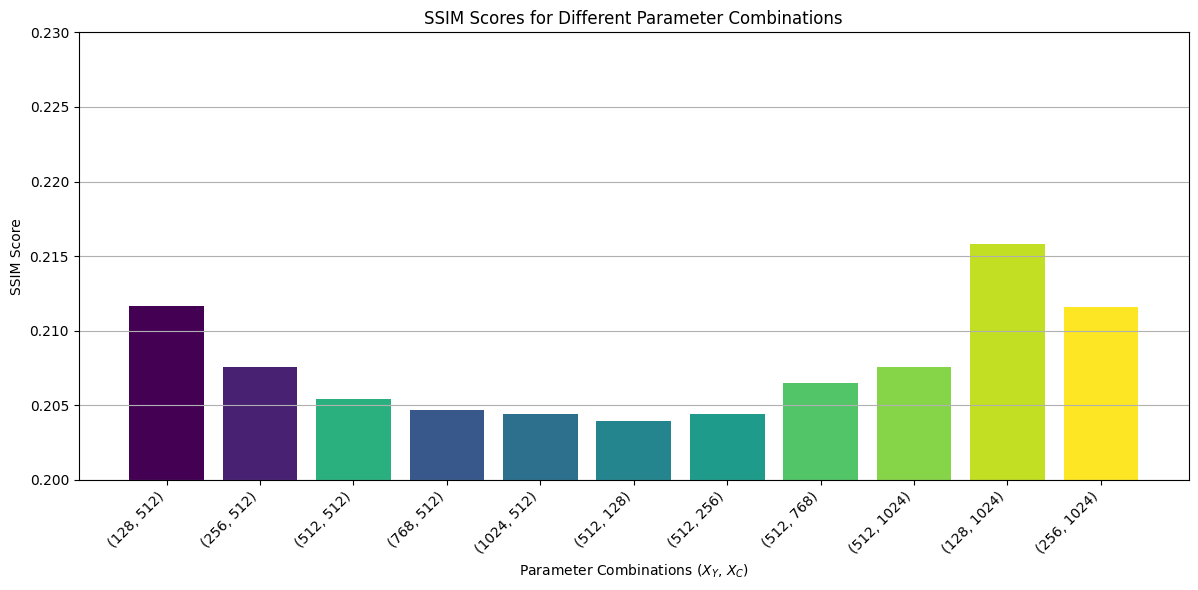

In [125]:
combinations = [f"({x_y}, {x_c})" for x_y, x_c, _ in ssim_scores]
scores = [ssim for _, _, ssim in ssim_scores]

# Generate random colors for each bar
colors = plt.cm.get_cmap('viridis', len(combinations))(range(len(combinations)))

# Plot the bar graph with different colors
plt.figure(figsize=(12, 6))
bars = plt.bar(combinations, scores, color=colors)
plt.xlabel('Parameter Combinations ($X_Y$, $X_C$)')
plt.ylabel('SSIM Score')
plt.title('SSIM Scores for Different Parameter Combinations')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.ylim(0.20, 0.225)
plt.show()